# FMLIKH Model: Stress Relaxation

## Learning Objectives

1. Generate **synthetic relaxation data** from NB07 calibrated parameters
2. Analyze **multi-exponential decay** with fractional memory
3. Compare Prony-series-like behavior with power-law modifications
4. Fit FMLIKH to relaxation data

## Prerequisites

- NB07: FMLIKH Flow Curve (calibrated parameters)
- NB03: FIKH Stress Relaxation (single-mode concepts)

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os, sys, time, warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

sys.path.insert(0, os.path.join("..", "utils"))
from fikh_tutorial_utils import (
    load_fikh_parameters, generate_synthetic_relaxation, save_fikh_results,
    set_model_parameters, print_convergence_summary, compute_fit_quality,
    get_fmlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Load Calibrated Parameters

In [3]:
N_MODES = 3
model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

try:
    params = load_fikh_parameters("fmlikh", "flow_curve")
    set_model_parameters(model, params)
    print("Loaded parameters from NB07")
except FileNotFoundError:
    print("Using default parameters")

Loaded parameters from NB07


## 3. Generate Synthetic Data

/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_44886/1668251304.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


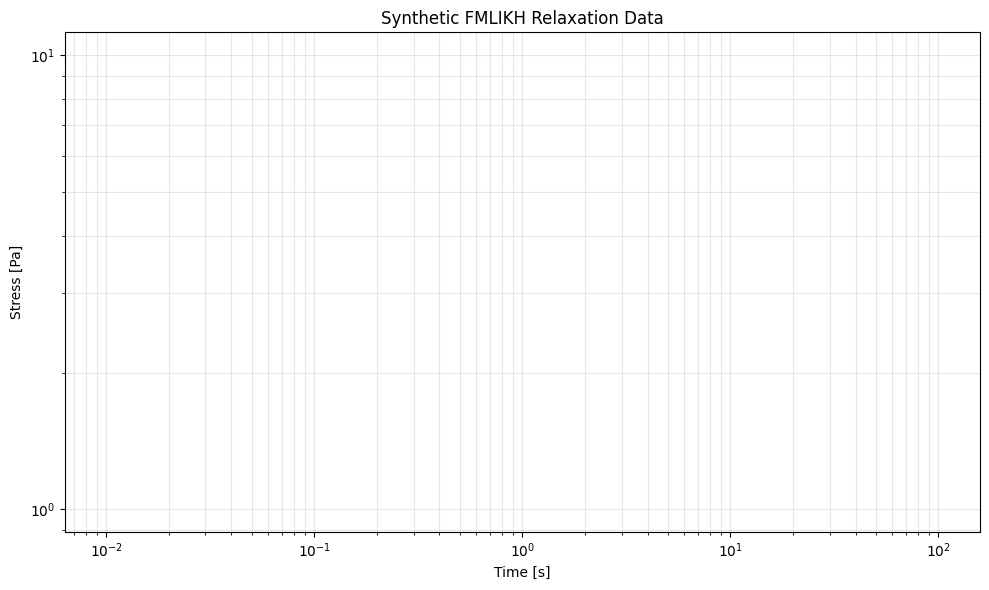

In [4]:
SIGMA_0 = 100.0
time_data, stress_data = generate_synthetic_relaxation(
    model, sigma_0=SIGMA_0, t_end=100.0, n_points=200, noise_level=0.03, seed=42
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(time_data, stress_data, "ko", markersize=5)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Synthetic FMLIKH Relaxation Data")
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# For relaxation: constant strain γ₀ = σ₀/G_total
try:
    G_total = sum(model.parameters.get_value(f'G_{i}') for i in range(N_MODES))
except (KeyError, AttributeError):
    G_total = 1000.0

gamma_0 = SIGMA_0 / max(G_total, 1.0)
strain_data = np.full_like(time_data, gamma_0)

model_fit = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.5)

t0 = time.time()
model_fit.fit(time_data, stress_data, test_mode="relaxation", strain=strain_data, method='scipy')
print(f"NLSQ time: {time.time() - t0:.2f} s")

stress_pred = model_fit.predict(time_data, test_mode="relaxation", strain=strain_data)
metrics = compute_fit_quality(stress_data, stress_pred)
print(f"R² = {metrics['R2']:.6f}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 383, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ time: 0.09 s
R² = 0.000000


/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_44886/1818943285.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


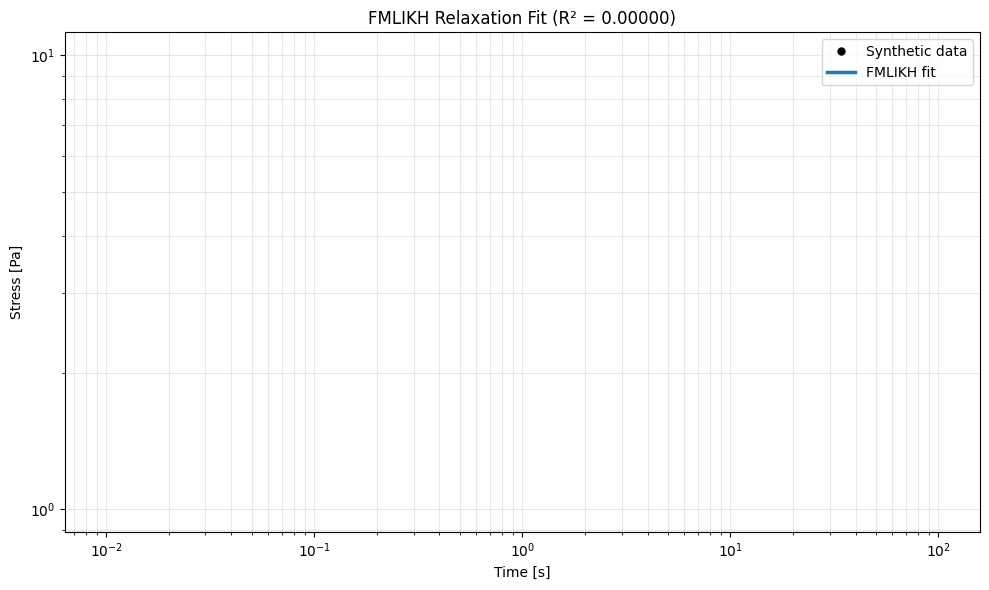

In [6]:
time_fine = np.logspace(np.log10(time_data.min()), np.log10(time_data.max()), 300)
strain_fine = np.full_like(time_fine, gamma_0)
stress_pred_fine = model_fit.predict(time_fine, test_mode="relaxation", strain=strain_fine)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(time_data, stress_data, "ko", markersize=5, label="Synthetic data")
ax.loglog(time_fine, stress_pred_fine, "-", lw=2.5, color="C0", label="FMLIKH fit")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title(f"FMLIKH Relaxation Fit (R² = {metrics['R2']:.5f})")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference

In [7]:
param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model_fit.parameters.get_value(n) for n in param_names if n in model_fit.parameters}

NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

t0 = time.time()
result = model_fit.fit_bayesian(
    time_data, stress_data, test_mode="relaxation", strain=strain_data,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
print(f"Bayesian time: {time.time() - t0:.1f} s")

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:05<59:36,  5.12s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|▏         | 10/700 [00:05<04:22,  2.63it/s, 3 steps of size 4.40e-05. acc. prob=0.60]

warmup:   2%|▏         | 16/700 [00:05<02:27,  4.62it/s, 31 steps of size 7.39e-05. acc. prob=0.75]

warmup:   3%|▎         | 21/700 [00:05<01:43,  6.56it/s, 31 steps of size 1.36e-04. acc. prob=0.81]

warmup:   4%|▍         | 29/700 [00:05<01:00, 11.05it/s, 7 steps of size 3.55e-04. acc. prob=0.86] 

warmup:   5%|▍         | 34/700 [00:05<00:47, 14.02it/s, 1 steps of size 6.12e-04. acc. prob=0.88]

warmup:   6%|▌         | 39/700 [00:05<00:39, 16.85it/s, 7 steps of size 1.01e-03. acc. prob=0.90]

warmup:   6%|▋         | 44/700 [00:06<00:31, 20.53it/s, 3 steps of size 1.59e-03. acc. prob=0.91]

warmup:   7%|▋         | 49/700 [00:09<02:19,  4.68it/s, 63 steps of size 2.41e-03. acc. prob=0.92]

warmup:   7%|▋         | 52/700 [00:09<02:21,  4.59it/s, 63 steps of size 3.05e-03. acc. prob=0.92]

warmup:   8%|▊         | 55/700 [00:10<02:07,  5.06it/s, 31 steps of size 3.81e-03. acc. prob=0.93]

warmup:   8%|▊         | 57/700 [00:10<02:04,  5.16it/s, 31 steps of size 4.39e-03. acc. prob=0.93]

warmup:   8%|▊         | 59/700 [00:10<02:03,  5.19it/s, 31 steps of size 5.04e-03. acc. prob=0.93]

warmup:   9%|▊         | 61/700 [00:11<02:03,  5.18it/s, 31 steps of size 5.77e-03. acc. prob=0.93]

warmup:   9%|▉         | 63/700 [00:11<01:46,  5.96it/s, 31 steps of size 6.57e-03. acc. prob=0.94]

warmup:   9%|▉         | 64/700 [00:11<01:51,  5.69it/s, 63 steps of size 7.00e-03. acc. prob=0.94]

warmup:   9%|▉         | 66/700 [00:12<01:46,  5.94it/s, 63 steps of size 7.92e-03. acc. prob=0.94]

warmup:  10%|▉         | 68/700 [00:12<01:25,  7.39it/s, 15 steps of size 8.94e-03. acc. prob=0.94]

warmup:  10%|█         | 71/700 [00:12<01:04,  9.69it/s, 15 steps of size 1.06e-02. acc. prob=0.94]

warmup:  10%|█         | 73/700 [00:12<00:57, 10.97it/s, 15 steps of size 1.19e-02. acc. prob=0.95]

warmup:  11%|█         | 75/700 [00:12<00:52, 12.01it/s, 31 steps of size 1.33e-02. acc. prob=0.95]

warmup:  11%|█         | 78/700 [00:12<00:41, 14.96it/s, 7 steps of size 1.56e-02. acc. prob=0.95] 

warmup:  12%|█▏        | 81/700 [00:12<00:34, 17.86it/s, 7 steps of size 1.82e-02. acc. prob=0.95]

warmup:  12%|█▏        | 84/700 [00:12<00:37, 16.42it/s, 15 steps of size 2.11e-02. acc. prob=0.95]

warmup:  12%|█▏        | 87/700 [00:13<00:32, 18.84it/s, 7 steps of size 2.43e-02. acc. prob=0.95] 

warmup:  13%|█▎        | 90/700 [00:13<00:30, 19.88it/s, 15 steps of size 2.79e-02. acc. prob=0.96]

warmup:  14%|█▎        | 96/700 [00:13<00:21, 27.81it/s, 7 steps of size 3.62e-02. acc. prob=0.96] 

warmup:  14%|█▍        | 101/700 [00:13<00:18, 32.55it/s, 3 steps of size 4.35e-01. acc. prob=0.96]

warmup:  16%|█▌        | 110/700 [00:13<00:12, 45.97it/s, 7 steps of size 2.48e-02. acc. prob=0.95]

warmup:  17%|█▋        | 117/700 [00:13<00:11, 49.81it/s, 7 steps of size 1.02e-02. acc. prob=0.95]

warmup:  18%|█▊        | 123/700 [00:13<00:12, 44.79it/s, 7 steps of size 5.38e-03. acc. prob=0.95]

warmup:  18%|█▊        | 128/700 [00:14<00:13, 41.38it/s, 12 steps of size 1.24e-03. acc. prob=0.95]

warmup:  19%|█▉        | 133/700 [00:14<00:17, 33.04it/s, 10 steps of size 7.36e-04. acc. prob=0.95]

warmup:  20%|█▉        | 137/700 [00:14<00:16, 33.16it/s, 9 steps of size 2.63e-04. acc. prob=0.95] 

warmup:  20%|██        | 141/700 [00:14<00:18, 30.10it/s, 19 steps of size 1.00e-04. acc. prob=0.95]

warmup:  21%|██        | 145/700 [00:14<00:19, 28.57it/s, 8 steps of size 5.11e-05. acc. prob=0.94] 

warmup:  21%|██▏       | 149/700 [00:15<00:27, 19.72it/s, 34 steps of size 2.66e-05. acc. prob=0.94]

warmup:  22%|██▏       | 152/700 [00:15<00:38, 14.10it/s, 2 steps of size 4.11e-05. acc. prob=0.94] 

warmup:  22%|██▏       | 156/700 [00:15<00:34, 15.71it/s, 30 steps of size 5.67e-06. acc. prob=0.94]

warmup:  23%|██▎       | 158/700 [00:15<00:38, 14.14it/s, 21 steps of size 4.26e-06. acc. prob=0.94]

warmup:  23%|██▎       | 160/700 [00:16<00:45, 11.79it/s, 45 steps of size 3.65e-06. acc. prob=0.94]

warmup:  23%|██▎       | 162/700 [00:16<00:54,  9.96it/s, 48 steps of size 3.35e-06. acc. prob=0.94]

warmup:  23%|██▎       | 164/700 [00:16<01:09,  7.74it/s, 55 steps of size 3.30e-06. acc. prob=0.94]

warmup:  24%|██▎       | 165/700 [00:17<01:18,  6.86it/s, 61 steps of size 3.32e-06. acc. prob=0.94]

warmup:  24%|██▍       | 167/700 [00:17<01:21,  6.56it/s, 78 steps of size 3.23e-06. acc. prob=0.94]

warmup:  24%|██▍       | 168/700 [00:17<01:31,  5.81it/s, 82 steps of size 3.32e-06. acc. prob=0.94]

warmup:  24%|██▍       | 169/700 [00:18<01:47,  4.94it/s, 74 steps of size 3.41e-06. acc. prob=0.94]

warmup:  24%|██▍       | 171/700 [00:18<01:39,  5.30it/s, 41 steps of size 3.18e-06. acc. prob=0.94]

warmup:  25%|██▍       | 172/700 [00:18<02:00,  4.38it/s, 61 steps of size 3.24e-06. acc. prob=0.94]

warmup:  25%|██▍       | 173/700 [00:19<02:23,  3.67it/s, 47 steps of size 3.26e-06. acc. prob=0.94]

warmup:  25%|██▍       | 174/700 [00:19<02:16,  3.87it/s, 48 steps of size 3.28e-06. acc. prob=0.94]

warmup:  25%|██▌       | 175/700 [00:19<02:12,  3.95it/s, 32 steps of size 3.21e-06. acc. prob=0.94]

warmup:  25%|██▌       | 177/700 [00:19<01:53,  4.61it/s, 50 steps of size 2.74e-06. acc. prob=0.94]

warmup:  25%|██▌       | 178/700 [00:20<01:52,  4.65it/s, 62 steps of size 2.80e-06. acc. prob=0.94]

warmup:  26%|██▌       | 179/700 [00:20<01:56,  4.47it/s, 64 steps of size 2.86e-06. acc. prob=0.94]

warmup:  26%|██▌       | 180/700 [00:20<01:44,  4.96it/s, 42 steps of size 2.87e-06. acc. prob=0.94]

warmup:  26%|██▌       | 181/700 [00:20<01:31,  5.65it/s, 26 steps of size 2.75e-06. acc. prob=0.94]

warmup:  26%|██▌       | 182/700 [00:20<01:42,  5.06it/s, 58 steps of size 2.81e-06. acc. prob=0.94]

warmup:  26%|██▌       | 183/700 [00:21<01:59,  4.33it/s, 86 steps of size 2.90e-06. acc. prob=0.94]

warmup:  26%|██▋       | 184/700 [00:21<01:52,  4.60it/s, 40 steps of size 2.89e-06. acc. prob=0.94]

warmup:  26%|██▋       | 185/700 [00:21<02:10,  3.96it/s, 95 steps of size 2.99e-06. acc. prob=0.94]

warmup:  27%|██▋       | 186/700 [00:21<02:00,  4.28it/s, 49 steps of size 3.02e-06. acc. prob=0.94]

warmup:  27%|██▋       | 187/700 [00:22<01:42,  5.02it/s, 24 steps of size 2.88e-06. acc. prob=0.94]

warmup:  27%|██▋       | 188/700 [00:22<01:39,  5.15it/s, 46 steps of size 2.90e-06. acc. prob=0.94]

warmup:  27%|██▋       | 189/700 [00:22<01:29,  5.70it/s, 30 steps of size 2.83e-06. acc. prob=0.94]

warmup:  27%|██▋       | 190/700 [00:22<01:25,  6.00it/s, 34 steps of size 2.78e-06. acc. prob=0.94]

warmup:  27%|██▋       | 191/700 [00:22<01:42,  4.99it/s, 59 steps of size 2.83e-06. acc. prob=0.94]

warmup:  27%|██▋       | 192/700 [00:22<01:33,  5.45it/s, 25 steps of size 2.72e-06. acc. prob=0.94]

warmup:  28%|██▊       | 193/700 [00:23<02:12,  3.81it/s, 62 steps of size 2.77e-06. acc. prob=0.94]

warmup:  28%|██▊       | 194/700 [00:23<02:01,  4.18it/s, 61 steps of size 2.82e-06. acc. prob=0.94]

warmup:  28%|██▊       | 195/700 [00:23<01:47,  4.69it/s, 41 steps of size 2.81e-06. acc. prob=0.94]

warmup:  28%|██▊       | 196/700 [00:23<01:43,  4.87it/s, 60 steps of size 2.86e-06. acc. prob=0.94]

warmup:  28%|██▊       | 197/700 [00:24<01:54,  4.41it/s, 69 steps of size 2.92e-06. acc. prob=0.94]

warmup:  28%|██▊       | 198/700 [00:24<02:02,  4.11it/s, 90 steps of size 3.00e-06. acc. prob=0.94]

warmup:  28%|██▊       | 199/700 [00:25<02:43,  3.07it/s, 131 steps of size 3.11e-06. acc. prob=0.94]

warmup:  29%|██▊       | 200/700 [00:25<02:25,  3.44it/s, 56 steps of size 3.00e-06. acc. prob=0.95] 

sample:  29%|██▊       | 201/700 [00:25<02:29,  3.34it/s, 106 steps of size 3.00e-06. acc. prob=0.99]

sample:  29%|██▉       | 205/700 [00:25<01:02,  7.88it/s, 4 steps of size 3.00e-06. acc. prob=0.80]  

sample:  30%|██▉       | 208/700 [00:25<00:48, 10.17it/s, 30 steps of size 3.00e-06. acc. prob=0.82]

sample:  30%|███       | 210/700 [00:26<00:50,  9.62it/s, 29 steps of size 3.00e-06. acc. prob=0.85]

sample:  30%|███       | 212/700 [00:26<00:49,  9.87it/s, 27 steps of size 3.00e-06. acc. prob=0.86]

sample:  31%|███       | 214/700 [00:26<00:52,  9.19it/s, 29 steps of size 3.00e-06. acc. prob=0.87]

sample:  31%|███       | 216/700 [00:26<00:51,  9.33it/s, 31 steps of size 3.00e-06. acc. prob=0.88]

sample:  31%|███       | 218/700 [00:26<00:51,  9.31it/s, 16 steps of size 3.00e-06. acc. prob=0.89]

sample:  32%|███▏      | 222/700 [00:27<00:34, 13.76it/s, 12 steps of size 3.00e-06. acc. prob=0.88]

sample:  32%|███▏      | 225/700 [00:27<00:33, 14.39it/s, 23 steps of size 3.00e-06. acc. prob=0.88]

sample:  32%|███▏      | 227/700 [00:27<00:32, 14.73it/s, 8 steps of size 3.00e-06. acc. prob=0.88] 

sample:  33%|███▎      | 230/700 [00:27<00:40, 11.49it/s, 42 steps of size 3.00e-06. acc. prob=0.89]

sample:  33%|███▎      | 232/700 [00:27<00:45, 10.33it/s, 20 steps of size 3.00e-06. acc. prob=0.89]

sample:  33%|███▎      | 234/700 [00:28<00:52,  8.87it/s, 24 steps of size 3.00e-06. acc. prob=0.90]

sample:  34%|███▎      | 236/700 [00:28<00:56,  8.26it/s, 38 steps of size 3.00e-06. acc. prob=0.90]

sample:  34%|███▍      | 237/700 [00:28<00:59,  7.82it/s, 21 steps of size 3.00e-06. acc. prob=0.90]

sample:  34%|███▍      | 238/700 [00:28<01:01,  7.52it/s, 49 steps of size 3.00e-06. acc. prob=0.90]

sample:  34%|███▍      | 239/700 [00:29<00:58,  7.88it/s, 29 steps of size 3.00e-06. acc. prob=0.91]

sample:  34%|███▍      | 240/700 [00:29<00:59,  7.71it/s, 36 steps of size 3.00e-06. acc. prob=0.91]

sample:  34%|███▍      | 241/700 [00:29<01:04,  7.16it/s, 45 steps of size 3.00e-06. acc. prob=0.91]

sample:  35%|███▍      | 242/700 [00:29<01:04,  7.11it/s, 48 steps of size 3.00e-06. acc. prob=0.91]

sample:  35%|███▍      | 243/700 [00:29<01:09,  6.58it/s, 48 steps of size 3.00e-06. acc. prob=0.91]

sample:  35%|███▍      | 244/700 [00:29<01:12,  6.33it/s, 50 steps of size 3.00e-06. acc. prob=0.91]

sample:  35%|███▌      | 245/700 [00:30<01:16,  5.98it/s, 62 steps of size 3.00e-06. acc. prob=0.92]

sample:  35%|███▌      | 246/700 [00:30<01:14,  6.06it/s, 43 steps of size 3.00e-06. acc. prob=0.92]

sample:  35%|███▌      | 248/700 [00:30<01:06,  6.78it/s, 54 steps of size 3.00e-06. acc. prob=0.92]

sample:  36%|███▌      | 249/700 [00:30<01:45,  4.27it/s, 91 steps of size 3.00e-06. acc. prob=0.92]

sample:  36%|███▌      | 250/700 [00:31<01:38,  4.58it/s, 41 steps of size 3.00e-06. acc. prob=0.92]

sample:  36%|███▌      | 251/700 [00:31<01:30,  4.94it/s, 40 steps of size 3.00e-06. acc. prob=0.92]

sample:  36%|███▌      | 252/700 [00:31<01:30,  4.93it/s, 56 steps of size 3.00e-06. acc. prob=0.92]

sample:  36%|███▌      | 253/700 [00:31<01:39,  4.49it/s, 43 steps of size 3.00e-06. acc. prob=0.92]

sample:  36%|███▋      | 254/700 [00:31<01:28,  5.04it/s, 41 steps of size 3.00e-06. acc. prob=0.93]

sample:  36%|███▋      | 255/700 [00:32<01:37,  4.58it/s, 63 steps of size 3.00e-06. acc. prob=0.93]

sample:  37%|███▋      | 256/700 [00:32<01:59,  3.71it/s, 105 steps of size 3.00e-06. acc. prob=0.93]

sample:  37%|███▋      | 257/700 [00:32<01:56,  3.80it/s, 80 steps of size 3.00e-06. acc. prob=0.93] 

sample:  37%|███▋      | 258/700 [00:33<01:51,  3.98it/s, 64 steps of size 3.00e-06. acc. prob=0.93]

sample:  37%|███▋      | 259/700 [00:33<01:46,  4.14it/s, 58 steps of size 3.00e-06. acc. prob=0.93]

sample:  37%|███▋      | 260/700 [00:33<02:04,  3.53it/s, 84 steps of size 3.00e-06. acc. prob=0.93]

sample:  37%|███▋      | 261/700 [00:33<01:42,  4.28it/s, 32 steps of size 3.00e-06. acc. prob=0.93]

sample:  37%|███▋      | 262/700 [00:33<01:38,  4.43it/s, 60 steps of size 3.00e-06. acc. prob=0.93]

sample:  38%|███▊      | 263/700 [00:34<01:40,  4.36it/s, 67 steps of size 3.00e-06. acc. prob=0.93]

sample:  38%|███▊      | 264/700 [00:34<01:41,  4.31it/s, 66 steps of size 3.00e-06. acc. prob=0.93]

sample:  38%|███▊      | 265/700 [00:34<01:33,  4.66it/s, 43 steps of size 3.00e-06. acc. prob=0.94]

sample:  38%|███▊      | 266/700 [00:34<01:28,  4.90it/s, 42 steps of size 3.00e-06. acc. prob=0.94]

sample:  38%|███▊      | 268/700 [00:34<01:08,  6.27it/s, 33 steps of size 3.00e-06. acc. prob=0.94]

sample:  38%|███▊      | 269/700 [00:35<01:07,  6.43it/s, 48 steps of size 3.00e-06. acc. prob=0.94]

sample:  39%|███▊      | 271/700 [00:35<00:51,  8.26it/s, 13 steps of size 3.00e-06. acc. prob=0.94]

sample:  39%|███▉      | 273/700 [00:35<00:40, 10.55it/s, 18 steps of size 3.00e-06. acc. prob=0.94]

sample:  39%|███▉      | 276/700 [00:35<00:29, 14.32it/s, 6 steps of size 3.00e-06. acc. prob=0.94] 

sample:  40%|███▉      | 278/700 [00:35<00:28, 15.02it/s, 25 steps of size 3.00e-06. acc. prob=0.93]

sample:  40%|████      | 280/700 [00:35<00:36, 11.50it/s, 55 steps of size 3.00e-06. acc. prob=0.94]

sample:  40%|████      | 282/700 [00:36<00:42,  9.86it/s, 46 steps of size 3.00e-06. acc. prob=0.94]

sample:  41%|████      | 284/700 [00:36<00:45,  9.13it/s, 35 steps of size 3.00e-06. acc. prob=0.94]

sample:  41%|████      | 286/700 [00:36<00:50,  8.18it/s, 38 steps of size 3.00e-06. acc. prob=0.94]

sample:  41%|████      | 287/700 [00:36<00:50,  8.14it/s, 39 steps of size 3.00e-06. acc. prob=0.94]

sample:  41%|████      | 288/700 [00:36<00:49,  8.33it/s, 26 steps of size 3.00e-06. acc. prob=0.94]

sample:  41%|████▏     | 289/700 [00:37<00:48,  8.53it/s, 29 steps of size 3.00e-06. acc. prob=0.94]

sample:  42%|████▏     | 291/700 [00:37<00:41,  9.90it/s, 17 steps of size 3.00e-06. acc. prob=0.94]

sample:  42%|████▏     | 293/700 [00:37<00:34, 11.89it/s, 2 steps of size 3.00e-06. acc. prob=0.93] 

sample:  42%|████▏     | 297/700 [00:37<00:27, 14.58it/s, 39 steps of size 3.00e-06. acc. prob=0.93]

sample:  43%|████▎     | 299/700 [00:37<00:29, 13.74it/s, 13 steps of size 3.00e-06. acc. prob=0.93]

sample:  43%|████▎     | 301/700 [00:37<00:34, 11.54it/s, 42 steps of size 3.00e-06. acc. prob=0.93]

sample:  43%|████▎     | 303/700 [00:38<00:36, 11.02it/s, 37 steps of size 3.00e-06. acc. prob=0.93]

sample:  44%|████▎     | 306/700 [00:38<00:30, 12.93it/s, 26 steps of size 3.00e-06. acc. prob=0.93]

sample:  44%|████▍     | 308/700 [00:38<00:30, 12.66it/s, 26 steps of size 3.00e-06. acc. prob=0.93]

sample:  44%|████▍     | 311/700 [00:38<00:24, 15.58it/s, 9 steps of size 3.00e-06. acc. prob=0.93] 

sample:  45%|████▍     | 314/700 [00:38<00:22, 16.86it/s, 17 steps of size 3.00e-06. acc. prob=0.93]

sample:  45%|████▌     | 316/700 [00:38<00:28, 13.30it/s, 23 steps of size 3.00e-06. acc. prob=0.93]

sample:  45%|████▌     | 318/700 [00:39<00:33, 11.47it/s, 24 steps of size 3.00e-06. acc. prob=0.93]

sample:  46%|████▌     | 321/700 [00:39<00:28, 13.31it/s, 10 steps of size 3.00e-06. acc. prob=0.93]

sample:  46%|████▌     | 323/700 [00:39<00:27, 13.79it/s, 5 steps of size 3.00e-06. acc. prob=0.93] 

sample:  46%|████▋     | 325/700 [00:39<00:32, 11.47it/s, 35 steps of size 3.00e-06. acc. prob=0.93]

sample:  47%|████▋     | 328/700 [00:40<00:31, 11.85it/s, 27 steps of size 3.00e-06. acc. prob=0.93]

sample:  47%|████▋     | 331/700 [00:40<00:27, 13.44it/s, 12 steps of size 3.00e-06. acc. prob=0.93]

sample:  48%|████▊     | 333/700 [00:40<00:28, 13.11it/s, 11 steps of size 3.00e-06. acc. prob=0.93]

sample:  48%|████▊     | 335/700 [00:40<00:29, 12.36it/s, 13 steps of size 3.00e-06. acc. prob=0.93]

sample:  48%|████▊     | 337/700 [00:40<00:39,  9.19it/s, 30 steps of size 3.00e-06. acc. prob=0.93]

sample:  48%|████▊     | 339/700 [00:41<00:39,  9.23it/s, 46 steps of size 3.00e-06. acc. prob=0.93]

sample:  49%|████▊     | 341/700 [00:41<00:51,  6.94it/s, 59 steps of size 3.00e-06. acc. prob=0.93]

sample:  49%|████▉     | 342/700 [00:41<00:58,  6.11it/s, 78 steps of size 3.00e-06. acc. prob=0.93]

sample:  49%|████▉     | 343/700 [00:41<00:55,  6.48it/s, 37 steps of size 3.00e-06. acc. prob=0.93]

sample:  49%|████▉     | 344/700 [00:42<00:59,  6.03it/s, 52 steps of size 3.00e-06. acc. prob=0.93]

sample:  49%|████▉     | 345/700 [00:42<00:54,  6.48it/s, 34 steps of size 3.00e-06. acc. prob=0.93]

sample:  49%|████▉     | 346/700 [00:42<01:01,  5.77it/s, 73 steps of size 3.00e-06. acc. prob=0.93]

sample:  50%|████▉     | 347/700 [00:42<01:12,  4.86it/s, 67 steps of size 3.00e-06. acc. prob=0.93]

sample:  50%|████▉     | 349/700 [00:42<00:53,  6.61it/s, 21 steps of size 3.00e-06. acc. prob=0.93]

sample:  50%|█████     | 351/700 [00:43<00:39,  8.75it/s, 18 steps of size 3.00e-06. acc. prob=0.93]

sample:  50%|█████     | 353/700 [00:43<00:34,  9.95it/s, 8 steps of size 3.00e-06. acc. prob=0.93] 

sample:  51%|█████     | 355/700 [00:43<00:34, 10.05it/s, 31 steps of size 3.00e-06. acc. prob=0.93]

sample:  51%|█████     | 357/700 [00:43<00:29, 11.44it/s, 10 steps of size 3.00e-06. acc. prob=0.93]

sample:  51%|█████▏    | 359/700 [00:43<00:34,  9.86it/s, 66 steps of size 3.00e-06. acc. prob=0.93]

sample:  52%|█████▏    | 361/700 [00:43<00:32, 10.44it/s, 31 steps of size 3.00e-06. acc. prob=0.93]

sample:  52%|█████▏    | 363/700 [00:44<00:28, 11.71it/s, 21 steps of size 3.00e-06. acc. prob=0.93]

sample:  52%|█████▏    | 365/700 [00:44<00:31, 10.48it/s, 50 steps of size 3.00e-06. acc. prob=0.93]

sample:  52%|█████▏    | 367/700 [00:44<00:34,  9.60it/s, 35 steps of size 3.00e-06. acc. prob=0.93]

sample:  53%|█████▎    | 369/700 [00:44<00:40,  8.17it/s, 30 steps of size 3.00e-06. acc. prob=0.93]

sample:  53%|█████▎    | 370/700 [00:45<00:43,  7.52it/s, 36 steps of size 3.00e-06. acc. prob=0.94]

sample:  53%|█████▎    | 371/700 [00:45<00:45,  7.24it/s, 37 steps of size 3.00e-06. acc. prob=0.94]

sample:  53%|█████▎    | 373/700 [00:45<00:40,  8.05it/s, 12 steps of size 3.00e-06. acc. prob=0.94]

sample:  53%|█████▎    | 374/700 [00:45<00:41,  7.84it/s, 33 steps of size 3.00e-06. acc. prob=0.94]

sample:  54%|█████▎    | 375/700 [00:45<00:50,  6.38it/s, 59 steps of size 3.00e-06. acc. prob=0.94]

sample:  54%|█████▎    | 376/700 [00:45<00:49,  6.58it/s, 10 steps of size 3.00e-06. acc. prob=0.94]

sample:  54%|█████▍    | 377/700 [00:46<00:47,  6.78it/s, 34 steps of size 3.00e-06. acc. prob=0.94]

sample:  54%|█████▍    | 378/700 [00:46<00:47,  6.84it/s, 31 steps of size 3.00e-06. acc. prob=0.94]

sample:  54%|█████▍    | 379/700 [00:46<01:03,  5.05it/s, 83 steps of size 3.00e-06. acc. prob=0.94]

sample:  54%|█████▍    | 380/700 [00:46<01:11,  4.46it/s, 55 steps of size 3.00e-06. acc. prob=0.94]

sample:  54%|█████▍    | 381/700 [00:47<01:12,  4.42it/s, 70 steps of size 3.00e-06. acc. prob=0.94]

sample:  55%|█████▍    | 382/700 [00:47<01:27,  3.64it/s, 110 steps of size 3.00e-06. acc. prob=0.94]

sample:  55%|█████▍    | 383/700 [00:48<02:21,  2.25it/s, 80 steps of size 3.00e-06. acc. prob=0.94] 

sample:  55%|█████▍    | 384/700 [00:48<02:05,  2.52it/s, 66 steps of size 3.00e-06. acc. prob=0.94]

sample:  55%|█████▌    | 385/700 [00:48<01:58,  2.66it/s, 72 steps of size 3.00e-06. acc. prob=0.94]

sample:  55%|█████▌    | 386/700 [00:49<01:49,  2.86it/s, 83 steps of size 3.00e-06. acc. prob=0.94]

sample:  55%|█████▌    | 387/700 [00:49<01:36,  3.24it/s, 67 steps of size 3.00e-06. acc. prob=0.94]

sample:  56%|█████▌    | 389/700 [00:49<01:12,  4.32it/s, 67 steps of size 3.00e-06. acc. prob=0.94]

sample:  56%|█████▌    | 391/700 [00:49<00:52,  5.84it/s, 29 steps of size 3.00e-06. acc. prob=0.94]

sample:  56%|█████▌    | 392/700 [00:50<00:49,  6.23it/s, 33 steps of size 3.00e-06. acc. prob=0.94]

sample:  56%|█████▌    | 393/700 [00:50<00:48,  6.39it/s, 48 steps of size 3.00e-06. acc. prob=0.94]

sample:  56%|█████▋    | 395/700 [00:50<00:35,  8.56it/s, 19 steps of size 3.00e-06. acc. prob=0.94]

sample:  57%|█████▋    | 397/700 [00:50<00:34,  8.89it/s, 17 steps of size 3.00e-06. acc. prob=0.94]

sample:  57%|█████▋    | 401/700 [00:50<00:24, 12.33it/s, 14 steps of size 3.00e-06. acc. prob=0.94]

sample:  58%|█████▊    | 403/700 [00:50<00:27, 10.63it/s, 29 steps of size 3.00e-06. acc. prob=0.94]

sample:  58%|█████▊    | 405/700 [00:51<00:26, 10.95it/s, 18 steps of size 3.00e-06. acc. prob=0.94]

sample:  58%|█████▊    | 408/700 [00:51<00:20, 13.98it/s, 4 steps of size 3.00e-06. acc. prob=0.94] 

sample:  60%|█████▉    | 417/700 [00:51<00:09, 28.64it/s, 2 steps of size 3.00e-06. acc. prob=0.92]

sample:  60%|██████    | 421/700 [00:51<00:09, 29.34it/s, 16 steps of size 3.00e-06. acc. prob=0.91]

sample:  61%|██████    | 425/700 [00:51<00:14, 18.91it/s, 16 steps of size 3.00e-06. acc. prob=0.91]

sample:  61%|██████    | 428/700 [00:52<00:14, 19.33it/s, 10 steps of size 3.00e-06. acc. prob=0.91]

sample:  62%|██████▏   | 431/700 [00:52<00:14, 18.27it/s, 34 steps of size 3.00e-06. acc. prob=0.91]

sample:  62%|██████▏   | 434/700 [00:52<00:19, 13.72it/s, 41 steps of size 3.00e-06. acc. prob=0.91]

sample:  62%|██████▏   | 436/700 [00:52<00:22, 11.63it/s, 38 steps of size 3.00e-06. acc. prob=0.92]

sample:  63%|██████▎   | 438/700 [00:53<00:27,  9.55it/s, 66 steps of size 3.00e-06. acc. prob=0.92]

sample:  63%|██████▎   | 440/700 [00:53<00:33,  7.77it/s, 39 steps of size 3.00e-06. acc. prob=0.92]

sample:  63%|██████▎   | 442/700 [00:53<00:30,  8.40it/s, 17 steps of size 3.00e-06. acc. prob=0.92]

sample:  64%|██████▎   | 445/700 [00:53<00:24, 10.57it/s, 26 steps of size 3.00e-06. acc. prob=0.92]

sample:  64%|██████▍   | 447/700 [00:54<00:31,  8.10it/s, 35 steps of size 3.00e-06. acc. prob=0.92]

sample:  64%|██████▍   | 449/700 [00:54<00:36,  6.91it/s, 40 steps of size 3.00e-06. acc. prob=0.92]

sample:  64%|██████▍   | 450/700 [00:55<00:40,  6.16it/s, 70 steps of size 3.00e-06. acc. prob=0.92]

sample:  64%|██████▍   | 451/700 [00:55<00:41,  5.99it/s, 47 steps of size 3.00e-06. acc. prob=0.92]

sample:  65%|██████▍   | 453/700 [00:55<00:33,  7.30it/s, 22 steps of size 3.00e-06. acc. prob=0.92]

sample:  65%|██████▌   | 455/700 [00:55<00:27,  8.88it/s, 13 steps of size 3.00e-06. acc. prob=0.92]

sample:  65%|██████▌   | 457/700 [00:55<00:28,  8.53it/s, 14 steps of size 3.00e-06. acc. prob=0.92]

sample:  65%|██████▌   | 458/700 [00:55<00:29,  8.18it/s, 27 steps of size 3.00e-06. acc. prob=0.92]

sample:  66%|██████▌   | 460/700 [00:56<00:26,  9.09it/s, 22 steps of size 3.00e-06. acc. prob=0.92]

sample:  66%|██████▌   | 462/700 [00:56<00:24,  9.79it/s, 20 steps of size 3.00e-06. acc. prob=0.92]

sample:  66%|██████▋   | 464/700 [00:56<00:27,  8.65it/s, 24 steps of size 3.00e-06. acc. prob=0.92]

sample:  66%|██████▋   | 465/700 [00:56<00:27,  8.50it/s, 34 steps of size 3.00e-06. acc. prob=0.92]

sample:  67%|██████▋   | 466/700 [00:56<00:33,  7.00it/s, 63 steps of size 3.00e-06. acc. prob=0.92]

sample:  67%|██████▋   | 467/700 [00:57<00:41,  5.68it/s, 59 steps of size 3.00e-06. acc. prob=0.92]

sample:  67%|██████▋   | 468/700 [00:57<00:40,  5.67it/s, 55 steps of size 3.00e-06. acc. prob=0.92]

sample:  67%|██████▋   | 469/700 [00:57<00:45,  5.08it/s, 50 steps of size 3.00e-06. acc. prob=0.92]

sample:  67%|██████▋   | 470/700 [00:57<00:41,  5.59it/s, 39 steps of size 3.00e-06. acc. prob=0.92]

sample:  67%|██████▋   | 471/700 [00:57<00:36,  6.27it/s, 30 steps of size 3.00e-06. acc. prob=0.92]

sample:  67%|██████▋   | 472/700 [00:58<00:38,  5.92it/s, 45 steps of size 3.00e-06. acc. prob=0.92]

sample:  68%|██████▊   | 474/700 [00:58<00:28,  8.02it/s, 20 steps of size 3.00e-06. acc. prob=0.92]

sample:  68%|██████▊   | 476/700 [00:58<00:23,  9.63it/s, 14 steps of size 3.00e-06. acc. prob=0.92]

sample:  68%|██████▊   | 478/700 [00:58<00:19, 11.35it/s, 7 steps of size 3.00e-06. acc. prob=0.92] 

sample:  69%|██████▊   | 480/700 [00:58<00:21, 10.40it/s, 37 steps of size 3.00e-06. acc. prob=0.92]

sample:  69%|██████▉   | 482/700 [00:58<00:24,  8.95it/s, 25 steps of size 3.00e-06. acc. prob=0.92]

sample:  69%|██████▉   | 483/700 [00:59<00:29,  7.32it/s, 79 steps of size 3.00e-06. acc. prob=0.92]

sample:  69%|██████▉   | 484/700 [00:59<00:30,  7.13it/s, 48 steps of size 3.00e-06. acc. prob=0.92]

sample:  69%|██████▉   | 485/700 [00:59<00:38,  5.63it/s, 85 steps of size 3.00e-06. acc. prob=0.92]

sample:  69%|██████▉   | 486/700 [00:59<00:46,  4.62it/s, 77 steps of size 3.00e-06. acc. prob=0.92]

sample:  70%|██████▉   | 487/700 [01:00<01:06,  3.19it/s, 65 steps of size 3.00e-06. acc. prob=0.92]

sample:  70%|██████▉   | 488/700 [01:00<01:03,  3.32it/s, 80 steps of size 3.00e-06. acc. prob=0.92]

sample:  70%|███████   | 490/700 [01:01<00:47,  4.43it/s, 49 steps of size 3.00e-06. acc. prob=0.92]

sample:  70%|███████   | 491/700 [01:01<00:48,  4.33it/s, 63 steps of size 3.00e-06. acc. prob=0.92]

sample:  70%|███████   | 493/700 [01:01<00:34,  6.00it/s, 23 steps of size 3.00e-06. acc. prob=0.92]

sample:  71%|███████   | 495/700 [01:01<00:28,  7.24it/s, 26 steps of size 3.00e-06. acc. prob=0.92]

sample:  71%|███████   | 496/700 [01:01<00:28,  7.25it/s, 41 steps of size 3.00e-06. acc. prob=0.92]

sample:  71%|███████   | 498/700 [01:02<00:24,  8.11it/s, 33 steps of size 3.00e-06. acc. prob=0.92]

sample:  71%|███████▏  | 500/700 [01:02<00:21,  9.29it/s, 20 steps of size 3.00e-06. acc. prob=0.92]

sample:  72%|███████▏  | 502/700 [01:02<00:29,  6.63it/s, 35 steps of size 3.00e-06. acc. prob=0.93]

sample:  72%|███████▏  | 507/700 [01:02<00:16, 11.77it/s, 18 steps of size 3.00e-06. acc. prob=0.92]

sample:  73%|███████▎  | 510/700 [01:02<00:13, 14.31it/s, 22 steps of size 3.00e-06. acc. prob=0.92]

sample:  74%|███████▎  | 515/700 [01:03<00:09, 19.82it/s, 7 steps of size 3.00e-06. acc. prob=0.91] 

sample:  74%|███████▍  | 518/700 [01:03<00:09, 19.98it/s, 16 steps of size 3.00e-06. acc. prob=0.91]

sample:  74%|███████▍  | 521/700 [01:03<00:17, 10.32it/s, 74 steps of size 3.00e-06. acc. prob=0.91]

sample:  75%|███████▍  | 523/700 [01:04<00:18,  9.36it/s, 61 steps of size 3.00e-06. acc. prob=0.91]

sample:  75%|███████▌  | 525/700 [01:04<00:19,  8.89it/s, 37 steps of size 3.00e-06. acc. prob=0.91]

sample:  75%|███████▌  | 527/700 [01:04<00:18,  9.35it/s, 3 steps of size 3.00e-06. acc. prob=0.91] 

sample:  76%|███████▌  | 529/700 [01:04<00:15, 10.79it/s, 14 steps of size 3.00e-06. acc. prob=0.91]

sample:  76%|███████▌  | 531/700 [01:04<00:16, 10.46it/s, 26 steps of size 3.00e-06. acc. prob=0.91]

sample:  76%|███████▌  | 533/700 [01:05<00:22,  7.36it/s, 60 steps of size 3.00e-06. acc. prob=0.92]

sample:  76%|███████▋  | 535/700 [01:05<00:22,  7.25it/s, 42 steps of size 3.00e-06. acc. prob=0.92]

sample:  77%|███████▋  | 537/700 [01:05<00:22,  7.27it/s, 66 steps of size 3.00e-06. acc. prob=0.92]

sample:  77%|███████▋  | 538/700 [01:06<00:22,  7.32it/s, 29 steps of size 3.00e-06. acc. prob=0.92]

sample:  77%|███████▋  | 541/700 [01:06<00:16,  9.58it/s, 12 steps of size 3.00e-06. acc. prob=0.92]

sample:  78%|███████▊  | 543/700 [01:06<00:14, 11.08it/s, 9 steps of size 3.00e-06. acc. prob=0.92] 

sample:  78%|███████▊  | 546/700 [01:06<00:11, 13.22it/s, 10 steps of size 3.00e-06. acc. prob=0.91]

sample:  78%|███████▊  | 549/700 [01:06<00:09, 15.68it/s, 16 steps of size 3.00e-06. acc. prob=0.91]

sample:  79%|███████▉  | 554/700 [01:06<00:06, 22.81it/s, 1 steps of size 3.00e-06. acc. prob=0.91] 

sample:  80%|████████  | 562/700 [01:06<00:04, 30.41it/s, 8 steps of size 3.00e-06. acc. prob=0.90]

sample:  81%|████████  | 566/700 [01:07<00:07, 19.13it/s, 8 steps of size 3.00e-06. acc. prob=0.90]

sample:  82%|████████▏ | 571/700 [01:07<00:05, 22.57it/s, 16 steps of size 3.00e-06. acc. prob=0.89]

sample:  82%|████████▏ | 574/700 [01:07<00:08, 14.01it/s, 62 steps of size 3.00e-06. acc. prob=0.89]

sample:  82%|████████▏ | 577/700 [01:08<00:08, 14.71it/s, 11 steps of size 3.00e-06. acc. prob=0.89]

sample:  83%|████████▎ | 580/700 [01:08<00:10, 11.88it/s, 28 steps of size 3.00e-06. acc. prob=0.89]

sample:  83%|████████▎ | 582/700 [01:08<00:09, 12.45it/s, 15 steps of size 3.00e-06. acc. prob=0.89]

sample:  83%|████████▎ | 584/700 [01:08<00:10, 11.29it/s, 20 steps of size 3.00e-06. acc. prob=0.90]

sample:  84%|████████▍ | 587/700 [01:09<00:08, 13.26it/s, 19 steps of size 3.00e-06. acc. prob=0.90]

sample:  84%|████████▍ | 589/700 [01:09<00:09, 11.36it/s, 26 steps of size 3.00e-06. acc. prob=0.90]

sample:  84%|████████▍ | 591/700 [01:09<00:11,  9.26it/s, 37 steps of size 3.00e-06. acc. prob=0.90]

sample:  85%|████████▍ | 593/700 [01:10<00:14,  7.13it/s, 38 steps of size 3.00e-06. acc. prob=0.90]

sample:  85%|████████▌ | 595/700 [01:10<00:12,  8.34it/s, 28 steps of size 3.00e-06. acc. prob=0.90]

sample:  85%|████████▌ | 598/700 [01:10<00:09, 10.87it/s, 18 steps of size 3.00e-06. acc. prob=0.90]

sample:  86%|████████▌ | 600/700 [01:10<00:10,  9.86it/s, 28 steps of size 3.00e-06. acc. prob=0.90]

sample:  86%|████████▌ | 602/700 [01:11<00:13,  7.19it/s, 53 steps of size 3.00e-06. acc. prob=0.90]

sample:  86%|████████▌ | 603/700 [01:11<00:14,  6.51it/s, 42 steps of size 3.00e-06. acc. prob=0.90]

sample:  86%|████████▋ | 604/700 [01:11<00:14,  6.58it/s, 46 steps of size 3.00e-06. acc. prob=0.90]

sample:  86%|████████▋ | 605/700 [01:11<00:15,  6.22it/s, 61 steps of size 3.00e-06. acc. prob=0.90]

sample:  87%|████████▋ | 606/700 [01:11<00:15,  6.24it/s, 50 steps of size 3.00e-06. acc. prob=0.90]

sample:  87%|████████▋ | 607/700 [01:11<00:14,  6.61it/s, 40 steps of size 3.00e-06. acc. prob=0.90]

sample:  87%|████████▋ | 608/700 [01:12<00:14,  6.49it/s, 52 steps of size 3.00e-06. acc. prob=0.90]

sample:  87%|████████▋ | 609/700 [01:12<00:13,  6.90it/s, 40 steps of size 3.00e-06. acc. prob=0.90]

sample:  87%|████████▋ | 610/700 [01:12<00:14,  6.04it/s, 24 steps of size 3.00e-06. acc. prob=0.90]

sample:  87%|████████▋ | 612/700 [01:12<00:11,  7.37it/s, 32 steps of size 3.00e-06. acc. prob=0.90]

sample:  88%|████████▊ | 613/700 [01:12<00:12,  7.17it/s, 45 steps of size 3.00e-06. acc. prob=0.90]

sample:  88%|████████▊ | 615/700 [01:13<00:21,  3.90it/s, 38 steps of size 3.00e-06. acc. prob=0.90]

sample:  88%|████████▊ | 616/700 [01:13<00:22,  3.67it/s, 25 steps of size 3.00e-06. acc. prob=0.90]

sample:  88%|████████▊ | 618/700 [01:14<00:17,  4.56it/s, 34 steps of size 3.00e-06. acc. prob=0.90]

sample:  89%|████████▊ | 620/700 [01:14<00:16,  4.89it/s, 41 steps of size 3.00e-06. acc. prob=0.90]

sample:  89%|████████▉ | 622/700 [01:14<00:14,  5.49it/s, 34 steps of size 3.00e-06. acc. prob=0.90]

sample:  89%|████████▉ | 624/700 [01:14<00:10,  7.01it/s, 22 steps of size 3.00e-06. acc. prob=0.90]

sample:  89%|████████▉ | 626/700 [01:15<00:08,  8.40it/s, 10 steps of size 3.00e-06. acc. prob=0.90]

sample:  90%|████████▉ | 628/700 [01:16<00:16,  4.37it/s, 67 steps of size 3.00e-06. acc. prob=0.90]

sample:  90%|████████▉ | 629/700 [01:16<00:14,  4.81it/s, 26 steps of size 3.00e-06. acc. prob=0.90]

sample:  90%|█████████ | 630/700 [01:16<00:13,  5.14it/s, 41 steps of size 3.00e-06. acc. prob=0.90]

sample:  90%|█████████ | 631/700 [01:16<00:12,  5.38it/s, 44 steps of size 3.00e-06. acc. prob=0.90]

sample:  90%|█████████ | 632/700 [01:16<00:13,  5.08it/s, 62 steps of size 3.00e-06. acc. prob=0.90]

sample:  90%|█████████ | 633/700 [01:16<00:12,  5.23it/s, 51 steps of size 3.00e-06. acc. prob=0.90]

sample:  91%|█████████ | 634/700 [01:17<00:13,  4.79it/s, 73 steps of size 3.00e-06. acc. prob=0.90]

sample:  91%|█████████ | 635/700 [01:17<00:12,  5.04it/s, 47 steps of size 3.00e-06. acc. prob=0.90]

sample:  91%|█████████ | 636/700 [01:17<00:11,  5.34it/s, 46 steps of size 3.00e-06. acc. prob=0.90]

sample:  91%|█████████ | 638/700 [01:17<00:08,  7.17it/s, 24 steps of size 3.00e-06. acc. prob=0.90]

sample:  91%|█████████▏| 639/700 [01:17<00:09,  6.49it/s, 57 steps of size 3.00e-06. acc. prob=0.90]

sample:  92%|█████████▏| 641/700 [01:18<00:08,  7.23it/s, 43 steps of size 3.00e-06. acc. prob=0.90]

sample:  92%|█████████▏| 642/700 [01:18<00:10,  5.80it/s, 91 steps of size 3.00e-06. acc. prob=0.90]

sample:  92%|█████████▏| 643/700 [01:18<00:12,  4.54it/s, 112 steps of size 3.00e-06. acc. prob=0.90]

sample:  92%|█████████▏| 644/700 [01:19<00:13,  4.18it/s, 89 steps of size 3.00e-06. acc. prob=0.90] 

sample:  92%|█████████▏| 645/700 [01:19<00:13,  4.04it/s, 80 steps of size 3.00e-06. acc. prob=0.90]

sample:  92%|█████████▏| 646/700 [01:19<00:12,  4.24it/s, 60 steps of size 3.00e-06. acc. prob=0.90]

sample:  92%|█████████▏| 647/700 [01:19<00:12,  4.34it/s, 46 steps of size 3.00e-06. acc. prob=0.90]

sample:  93%|█████████▎| 648/700 [01:19<00:12,  4.09it/s, 51 steps of size 3.00e-06. acc. prob=0.90]

sample:  93%|█████████▎| 649/700 [01:20<00:13,  3.70it/s, 106 steps of size 3.00e-06. acc. prob=0.90]

sample:  93%|█████████▎| 650/700 [01:20<00:12,  4.05it/s, 61 steps of size 3.00e-06. acc. prob=0.90] 

sample:  93%|█████████▎| 651/700 [01:20<00:12,  3.80it/s, 75 steps of size 3.00e-06. acc. prob=0.90]

sample:  93%|█████████▎| 652/700 [01:21<00:13,  3.63it/s, 69 steps of size 3.00e-06. acc. prob=0.91]

sample:  93%|█████████▎| 653/700 [01:21<00:11,  3.94it/s, 57 steps of size 3.00e-06. acc. prob=0.91]

sample:  93%|█████████▎| 654/700 [01:21<00:09,  4.67it/s, 37 steps of size 3.00e-06. acc. prob=0.91]

sample:  94%|█████████▎| 656/700 [01:21<00:07,  5.86it/s, 52 steps of size 3.00e-06. acc. prob=0.91]

sample:  94%|█████████▍| 657/700 [01:21<00:06,  6.36it/s, 36 steps of size 3.00e-06. acc. prob=0.91]

sample:  94%|█████████▍| 658/700 [01:22<00:08,  5.24it/s, 27 steps of size 3.00e-06. acc. prob=0.91]

sample:  94%|█████████▍| 659/700 [01:22<00:07,  5.75it/s, 34 steps of size 3.00e-06. acc. prob=0.91]

sample:  94%|█████████▍| 661/700 [01:22<00:04,  7.85it/s, 27 steps of size 3.00e-06. acc. prob=0.91]

sample:  95%|█████████▍| 663/700 [01:22<00:03,  9.82it/s, 20 steps of size 3.00e-06. acc. prob=0.91]

sample:  95%|█████████▌| 665/700 [01:22<00:03,  9.94it/s, 12 steps of size 3.00e-06. acc. prob=0.91]

sample:  95%|█████████▌| 668/700 [01:22<00:02, 13.80it/s, 5 steps of size 3.00e-06. acc. prob=0.91] 

sample:  96%|█████████▌| 672/700 [01:22<00:01, 17.30it/s, 22 steps of size 3.00e-06. acc. prob=0.90]

sample:  96%|█████████▋| 674/700 [01:23<00:01, 17.83it/s, 3 steps of size 3.00e-06. acc. prob=0.90] 

sample:  97%|█████████▋| 678/700 [01:23<00:00, 22.88it/s, 2 steps of size 3.00e-06. acc. prob=0.90]

sample:  97%|█████████▋| 681/700 [01:23<00:01, 14.57it/s, 66 steps of size 3.00e-06. acc. prob=0.90]

sample:  98%|█████████▊| 683/700 [01:23<00:01,  9.83it/s, 75 steps of size 3.00e-06. acc. prob=0.90]

sample:  98%|█████████▊| 685/700 [01:24<00:02,  5.06it/s, 79 steps of size 3.00e-06. acc. prob=0.90]

sample:  98%|█████████▊| 687/700 [01:25<00:02,  5.09it/s, 73 steps of size 3.00e-06. acc. prob=0.90]

sample:  98%|█████████▊| 688/700 [01:25<00:02,  5.19it/s, 51 steps of size 3.00e-06. acc. prob=0.90]

sample:  98%|█████████▊| 689/700 [01:25<00:02,  5.11it/s, 50 steps of size 3.00e-06. acc. prob=0.90]

sample:  99%|█████████▊| 690/700 [01:25<00:01,  5.61it/s, 31 steps of size 3.00e-06. acc. prob=0.90]

sample:  99%|█████████▉| 692/700 [01:26<00:01,  6.06it/s, 74 steps of size 3.00e-06. acc. prob=0.90]

sample:  99%|█████████▉| 693/700 [01:26<00:01,  6.34it/s, 39 steps of size 3.00e-06. acc. prob=0.90]

sample:  99%|█████████▉| 694/700 [01:26<00:01,  5.46it/s, 50 steps of size 3.00e-06. acc. prob=0.90]

sample:  99%|█████████▉| 695/700 [01:26<00:00,  5.21it/s, 54 steps of size 3.00e-06. acc. prob=0.90]

sample:  99%|█████████▉| 696/700 [01:26<00:00,  5.12it/s, 61 steps of size 3.00e-06. acc. prob=0.91]

sample: 100%|█████████▉| 697/700 [01:27<00:00,  5.07it/s, 61 steps of size 3.00e-06. acc. prob=0.91]

sample: 100%|█████████▉| 698/700 [01:27<00:00,  4.02it/s, 96 steps of size 3.00e-06. acc. prob=0.91]

sample: 100%|█████████▉| 699/700 [01:27<00:00,  3.64it/s, 46 steps of size 3.00e-06. acc. prob=0.91]

sample: 100%|██████████| 700/700 [01:28<00:00,  3.81it/s, 70 steps of size 3.00e-06. acc. prob=0.91]

sample: 100%|██████████| 700/700 [01:28<00:00,  7.95it/s, 70 steps of size 3.00e-06. acc. prob=0.91]

Bayesian time: 94.9 s


In [8]:
key_params = ["G_0", "G_1", "alpha_structure"]
print_convergence_summary(result, key_params)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    1.0000       500      PASS
            G_1    1.0000       500      PASS
alpha_structure    1.0000       500      PASS

Divergences: 500

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


False

## 6. Save Results

In [9]:
save_fikh_results(model_fit, result, "fmlikh", "relaxation", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/fikh/../utils/../outputs/fikh/fmlikh/relaxation/
  nlsq_params_relaxation.json: 20 parameters
  posterior_relaxation.json: 500 draws


## Key Takeaways

1. **Multi-mode relaxation** shows multiple decay time scales
2. **Fractional order** modifies each mode's decay character
3. **Log-log plots** reveal power-law tails from fractional memory
4. **Relaxation data constrains** mode distribution and alpha